In [1]:
# Importaciones base para geoespacial y gráficos
import warnings  # suprime warnings no críticos
warnings.filterwarnings("ignore")

import numpy as np                # cálculos numéricos
import pandas as pd               # tablas y CSV
import geopandas as gpd           # vectores (shapefiles/geojson)
import rasterio                   # lectura de rasters (GeoTIFF)
from rasterio.enums import Resampling  # por si necesitas muestrear
from rasterstats import zonal_stats    # estadísticas zonales
import matplotlib.pyplot as plt   # gráficos estáticos
from shapely.geometry import shape
import shapely                    # utilidades geométricas (validación, fix)
import unicodedata                # para quitar tildes en nombres
from pathlib import Path          # rutas relativas robustas

# Ruta base: esta celda asume que el .ipynb está en /notebooks/
BASE = Path.cwd().parent          # apunta a raíz del repo
DATA = BASE / "data"              # carpeta data en la raíz del repo

print("BASE:", BASE)
print("DATA:", DATA)


BASE: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster
DATA: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data


In [7]:
# Rutas relativas (desde /notebooks/)
RASTER_PATH = DATA / "tmin_raster.tif"                          # raster Tmin
SHAPE_PATH  = DATA / "shape_file" / "DISTRITOS.shp"        # shapefile de distritos

# Parámetros analíticos por defecto
FROST_THRESHOLD_C = 0.0     # umbral de helada para frost_share (°C)
ALL_TOUCHED = False         # True: incluye píxeles tocados por el borde; False: centro del píxel
MAP_VAR = "mean"            # variable para el mapa estático: "mean" o "p10"
RANK_K = 15                 # tamaño del ranking Top/Bottom


In [3]:
# Cargar distritos
gdf = gpd.read_file(SHAPE_PATH)  # carga el shapefile
print("Filas:", len(gdf))
print("CRS del shapefile:", gdf.crs)
print("Columnas:", list(gdf.columns)[:10], "...")  # muestra las primeras columnas

# Vista rápida
gdf.head(3)


Filas: 1873
CRS del shapefile: epsg:4326
Columnas: ['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE'] ...


,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.31710 -9.297..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."


In [4]:
FIELD_UBIGEO = "IDDIST"    # IDDIST es el UBIGEO distrital
FIELD_NAME   = "DISTRITO"  # Nombre del distrito

def quitar_tildes(s):
    import unicodedata
    if pd.isna(s):
        return s
    s = str(s).upper()
    s = unicodedata.normalize('NFKD', s).encode('ASCII', 'ignore').decode('ASCII')
    return s

# UBIGEO como string de 6 dígitos (p. ej., '150101')
gdf["__UBIGEO__"] = gdf[FIELD_UBIGEO].astype(str).str.strip().str.zfill(6)

# Nombre estandarizado (MAYÚSCULAS sin tildes)
gdf["__NOMBRE__"] = gdf[FIELD_NAME].apply(quitar_tildes)

# Chequeos rápidos
print("Campo UBIGEO usado:", FIELD_UBIGEO)
print("Campo NOMBRE usado:", FIELD_NAME)
print("UBIGEO únicos:", gdf["__UBIGEO__"].nunique(), "/", len(gdf))
print("Duplicados UBIGEO:", gdf["__UBIGEO__"].duplicated().sum())
display(gdf[["__UBIGEO__", "__NOMBRE__"]].head(5))


Campo UBIGEO usado: IDDIST
Campo NOMBRE usado: DISTRITO
UBIGEO únicos: 1873 / 1873
Duplicados UBIGEO: 0


,__UBIGEO__,__NOMBRE__
0,100902,CODO DEL POZUZO
1,100904,TOURNAVISTA
2,250305,ALEXANDER VON HUMBOLDT
3,250302,IRAZOLA
4,250304,NESHUYA


In [5]:
# Revisa geometrías inválidas y arréglalas (evita fallos en el recorte)
invalidas = ~gdf.is_valid
print("Geometrías inválidas:", invalidas.sum())

if invalidas.any():
    try:
        # Shapely 2.x
        gdf.loc[invalidas, "geometry"] = gdf.loc[invalidas, "geometry"].apply(shapely.make_valid)
        print("Fix con shapely.make_valid aplicado.")
    except Exception as e:
        # Fallback clásico
        gdf.loc[invalidas, "geometry"] = gdf.loc[invalidas, "geometry"].buffer(0)
        print("Fix con buffer(0) aplicado (fallback).")
    print("Inválidas después del fix:", (~gdf.is_valid).sum())
else:
    print("Todas las geometrías son válidas.")


Geometrías inválidas: 0
Todas las geometrías son válidas.


In [8]:
with rasterio.open(RASTER_PATH) as src:
    raster_crs = src.crs
    band_count = src.count
    nodata_val = src.nodata
    dtype = src.dtypes[0]
    width, height = src.width, src.height

    # Lee banda 1 (masked=True ignora NoData) y toma una muestra para estimar rangos
    arr = src.read(1, masked=True)
    vals = arr.compressed()  # 1D de valores válidos
    sample = vals[::max(1, int(len(vals)/200000))] if vals.size else np.array([])  # submuestreo para memoria
    v_min = float(np.nanmin(sample)) if sample.size else np.nan
    v_max = float(np.nanmax(sample)) if sample.size else np.nan

print(f"CRS raster: {raster_crs} | Bandas: {band_count} | dtype: {dtype} | NoData: {nodata_val}")
print(f"Dimensiones: {width}x{height} | Rango estimado (band 1): min={v_min}, max={v_max}")

# Heurística de escala: si es entero y los valores son del orden de cientos, asumimos escala x10
SCALE_MULT = 0.1 if (np.isfinite(v_max) and str(dtype).startswith("int") and abs(v_max) > 100) else 1.0
print(f"SCALE_MULT (factor para convertir a °C): {SCALE_MULT}  -> 1.0=ya en °C; 0.1=venía en °C×10")


CRS raster: EPSG:4326 | Bandas: 5 | dtype: float32 | NoData: None
Dimensiones: 285x397 | Rango estimado (band 1): min=-9.052620887756348, max=24.63677406311035
SCALE_MULT (factor para convertir a °C): 1.0  -> 1.0=ya en °C; 0.1=venía en °C×10


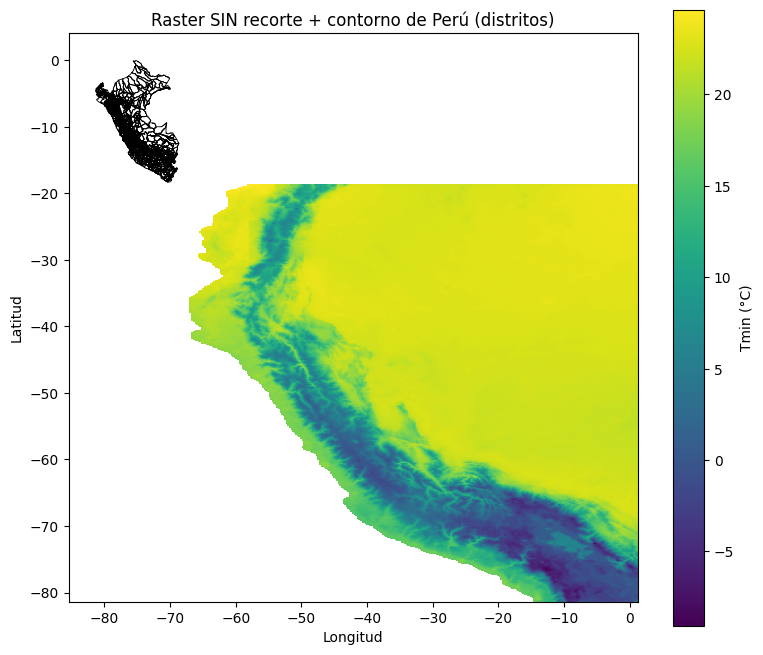

In [9]:
# Vista rápida del raster completo (antes de recortar) y el contorno de Perú
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.patches as mpatches

# Usamos la banda 1 solo para visualización
with rasterio.open(RASTER_PATH) as src:
    arr_viz = src.read(1, masked=True)   # masked=True ignora NoData
    extent = rasterio.transform.array_bounds(src.height, src.width, src.transform)  # (miny, maxy, minx, maxx)
    # array_bounds devuelve (min_y, max_y, min_x, max_x); para extent necesitamos (min_x, max_x, min_y, max_y)
    miny, maxy, minx, maxx = extent
    extent_xy = (minx, maxx, miny, maxy)

# Reproyectar gdf si fuese necesario (por seguridad, aunque ya deberías tener el CRS alineado)
gdf_plot = gdf.to_crs(raster_crs)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(arr_viz, extent=extent_xy, origin='upper')  # raster bruto
gdf_plot.boundary.plot(ax=ax, linewidth=0.6, color='black')  # contorno Perú (distritos)

ax.set_title("Raster SIN recorte + contorno de Perú (distritos)")
ax.set_xlabel("Longitud"); ax.set_ylabel("Latitud")
cbar = plt.colorbar(im, ax=ax, shrink=0.8); cbar.set_label("Tmin (°C)")
plt.tight_layout()
plt.show()


In [10]:
# Recortar raster a Perú usando la geometría disuelta (un solo polígono)
from rasterio.mask import mask
from shapely.ops import unary_union

# Disolver todas las geometrías distritales para tener un polígono nacional
geom_peru = gdf.geometry.unary_union              # shapely geometry
geoms = [geom_peru.__geo_interface__]            # formato GeoJSON para rasterio.mask

# Definimos un NoData para salida si el raster no lo tiene (float32 no soporta NaN en GeoTIFF clásico)
NODATA_OUT = -9999.0 if nodata_val is None else nodata_val

with rasterio.open(RASTER_PATH) as src:
    out_image, out_transform = mask(src, geoms, crop=True, nodata=NODATA_OUT)
    out_meta = src.meta.copy()

# Actualiza metadatos para el recorte
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": NODATA_OUT
})

print("Recorte realizado. Dimensiones nuevas:", out_image.shape)


Recorte realizado. Dimensiones nuevas: (5, 368, 254)


In [11]:
# Guardar el raster recortado (todas las bandas) en /data/
RASTER_CLIPPED_PATH = DATA / "tmin_raster_peru.tif"

with rasterio.open(RASTER_CLIPPED_PATH, "w", **out_meta) as dest:
    dest.write(out_image)

print("Guardado:", RASTER_CLIPPED_PATH)
print("Existe:", RASTER_CLIPPED_PATH.exists())


Guardado: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\tmin_raster_peru.tif
Existe: True


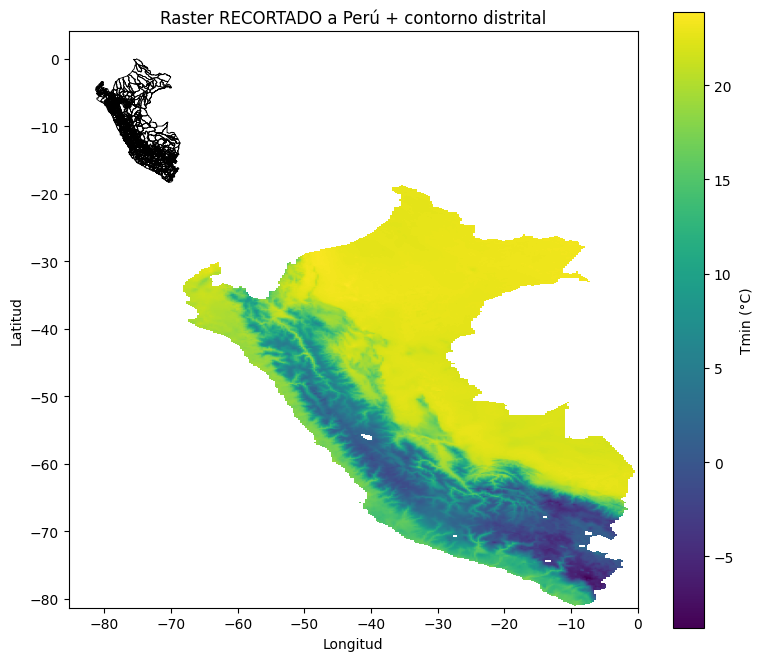

In [12]:
# Visualización para confirmar que el recorte quedó bien
with rasterio.open(RASTER_CLIPPED_PATH) as src:
    arr_viz_clip = src.read(1, masked=True)
    extent = rasterio.transform.array_bounds(src.height, src.width, src.transform)
    miny, maxy, minx, maxx = extent
    extent_xy_clip = (minx, maxx, miny, maxy)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(arr_viz_clip, extent=extent_xy_clip, origin='upper')
gdf_plot.boundary.plot(ax=ax, linewidth=0.6, color='black')

ax.set_title("Raster RECORTADO a Perú + contorno distrital")
ax.set_xlabel("Longitud"); ax.set_ylabel("Latitud")
cbar = plt.colorbar(im, ax=ax, shrink=0.8); cbar.set_label("Tmin (°C)")
plt.tight_layout()
plt.show()


In [14]:
RASTER_PATH = RASTER_CLIPPED_PATH   # usar el recortado para las zonal stats
print("RASTER_PATH actualizado a:", RASTER_PATH.name)

RASTER_PATH actualizado a: tmin_raster_peru.tif


In [15]:
if gdf.crs != raster_crs:
    print("Reproyectando distritos al CRS del raster...")
    gdf = gdf.to_crs(raster_crs)
else:
    print("CRS ya alineados.")

gdf = gdf.reset_index(drop=True)  # índice limpio para uniones posteriores


CRS ya alineados.


In [16]:
def zonalstats_band(gdf, raster_path, band=1, nodata=None, scale_mult=1.0, 
                    frost_threshold_c=0.0, all_touched=False):
    """
    Calcula estadísticas zonales para un band específico del raster.
    Devuelve un DataFrame con:
    __UBIGEO__, __NOMBRE__, band_label, count, mean, min, max, std, p10, p90, frost_share
    """
    # Extrae mini-rasters por polígono (raster_out=True) para calcular métricas con re-escalado controlado
    zs = zonal_stats(
        gdf,
        raster_path,
        band=band,
        stats=["count"],         # pedimos count; el resto lo calculamos manualmente para aplicar scale_mult
        nodata=nodata,
        all_touched=all_touched,
        raster_out=True
    )

    registros = []
    for i, res in enumerate(zs):
        mini = res.get("mini_raster_array", None)
        if mini is None:
            # Sin intersección: deja NaN y count=0
            registros.append({
                "__UBIGEO__": gdf.loc[i, "__UBIGEO__"],
                "__NOMBRE__": gdf.loc[i, "__NOMBRE__"],
                "band_label": f"band_{band:02d}",
                "count": 0, "mean": np.nan, "min": np.nan, "max": np.nan, "std": np.nan,
                "p10": np.nan, "p90": np.nan, "frost_share": np.nan
            })
            continue

        # Convierte a 1D, filtra nodata (si no viene masked) y reescala a °C
        if hasattr(mini, "compressed"):
            vals = mini.compressed().astype(float)
        else:
            vals = np.array(mini, dtype=float).ravel()
            if nodata is not None:
                vals = vals[vals != nodata]

        vals = vals * scale_mult  # reescalado (°C)

        # Métricas básicas + percentiles + métrica personalizada
        if vals.size == 0:
            count = 0
            mean = minv = maxv = stdv = p10 = p90 = np.nan
            frost_share = np.nan
        else:
            count = int(vals.size)
            mean  = float(np.nanmean(vals))
            minv  = float(np.nanmin(vals))
            maxv  = float(np.nanmax(vals))
            stdv  = float(np.nanstd(vals, ddof=0))
            p10   = float(np.nanpercentile(vals, 10))
            p90   = float(np.nanpercentile(vals, 90))
            frost_share = float((vals < frost_threshold_c).sum() / count)

        registros.append({
            "__UBIGEO__": gdf.loc[i, "__UBIGEO__"],
            "__NOMBRE__": gdf.loc[i, "__NOMBRE__"],
            "band_label": f"band_{band:02d}",
            "count": count, "mean": mean, "min": minv, "max": maxv, "std": stdv,
            "p10": p10, "p90": p90, "frost_share": frost_share
        })

    return pd.DataFrame(registros)


In [17]:
# Detecta cuántas bandas tiene el raster
with rasterio.open(RASTER_PATH) as src:
    BANDS = list(range(1, src.count + 1))

dfs = []
for b in BANDS:
    print(f"Procesando banda {b}/{len(BANDS)}...")
    dfb = zonalstats_band(
        gdf,
        RASTER_PATH,
        band=b,
        nodata=nodata_val,
        scale_mult=SCALE_MULT,
        frost_threshold_c=FROST_THRESHOLD_C,
        all_touched=ALL_TOUCHED
    )
    dfs.append(dfb)

df_stats = pd.concat(dfs, ignore_index=True)
print("Shape df_stats:", df_stats.shape)
df_stats.head(3)


Procesando banda 1/5...
Procesando banda 2/5...
Procesando banda 3/5...
Procesando banda 4/5...
Procesando banda 5/5...
Shape df_stats: (9365, 11)


,__UBIGEO__,__NOMBRE__,band_label,count,mean,min,max,std,p10,p90,frost_share
0,100902,CODO DEL POZUZO,band_01,107,18.932154,8.903979,22.604116,3.430219,13.836891,22.358987,0.0
1,100904,TOURNAVISTA,band_01,57,22.290649,19.775057,22.860834,0.464426,21.992695,22.676195,0.0
2,250305,ALEXANDER VON HUMBOLDT,band_01,6,22.056367,21.953405,22.141968,0.076649,21.955791,22.137794,0.0


In [18]:
# Exporta una tabla maestra con todas las bandas y métricas (para que la app no recalcule)
OUT_MASTER = DATA / "tmin_zstats_distrito.csv"
df_stats.to_csv(OUT_MASTER, index=False, encoding="utf-8")
print("Guardado CSV maestro:", OUT_MASTER)


Guardado CSV maestro: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\tmin_zstats_distrito.csv


In [21]:
# Usaremos la última banda disponible 
DEFAULT_BAND = df_stats["band_label"].unique()[-1]
print("DEFAULT_BAND:", DEFAULT_BAND)

df_one = df_stats[df_stats["band_label"] == DEFAULT_BAND].copy()
print("Filas periodo seleccionado:", len(df_one))
df_one.head(3)


DEFAULT_BAND: band_05
Filas periodo seleccionado: 1873


,__UBIGEO__,__NOMBRE__,band_label,count,mean,min,max,std,p10,p90,frost_share
7492,100902,CODO DEL POZUZO,band_05,107,18.754149,9.002318,22.482599,3.358801,13.774815,22.178958,0.0
7493,100904,TOURNAVISTA,band_05,57,22.099378,19.724146,22.625916,0.434192,21.788777,22.438683,0.0
7494,250305,ALEXANDER VON HUMBOLDT,band_05,6,21.840639,21.680176,21.938402,0.088975,21.723733,21.922051,0.0


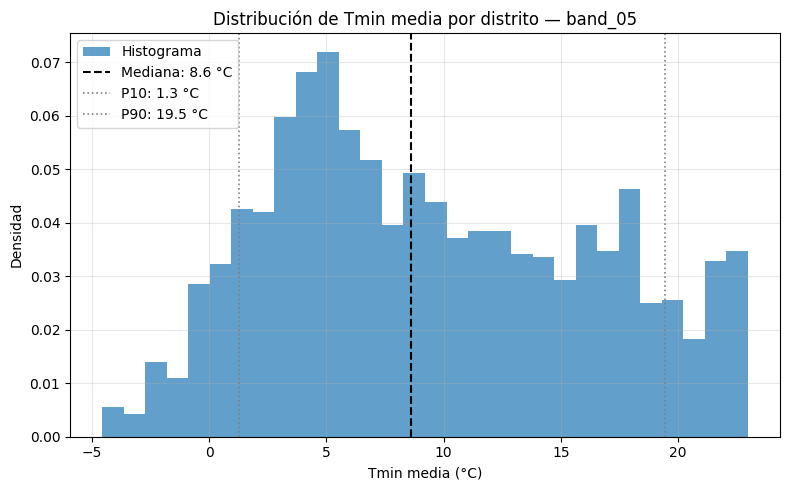

Guardado: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\dist_tmin_mean_distrito_band_05.png


In [22]:
plt.figure(figsize=(8,5))

# Histograma con densidad
df_one["mean"].plot(kind="hist", bins=30, density=True, alpha=0.7, label="Histograma")

# Líneas guía: mediana y percentiles 10/90 (ya calculados en df_one, pero aquí los recomputamos con numpy)
mediana = float(np.nanmedian(df_one["mean"]))
p10 = float(np.nanpercentile(df_one["mean"], 10))
p90 = float(np.nanpercentile(df_one["mean"], 90))

plt.axvline(mediana, color="k", linestyle="--", linewidth=1.5, label=f"Mediana: {mediana:.1f} °C")
plt.axvline(p10, color="gray", linestyle=":", linewidth=1.2, label=f"P10: {p10:.1f} °C")
plt.axvline(p90, color="gray", linestyle=":", linewidth=1.2, label=f"P90: {p90:.1f} °C")

plt.title(f"Distribución de Tmin media por distrito — {DEFAULT_BAND}")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, alpha=0.3)

OUT_DIST = DATA / f"dist_tmin_mean_distrito_{DEFAULT_BAND}.png"
plt.tight_layout()
plt.savefig(OUT_DIST, dpi=150)
plt.show()
print("Guardado:", OUT_DIST)


Guardados: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\ranking_tmin_mean_top15_distrito_band_05.csv y c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\ranking_tmin_mean_bottom15_distrito_band_05.csv


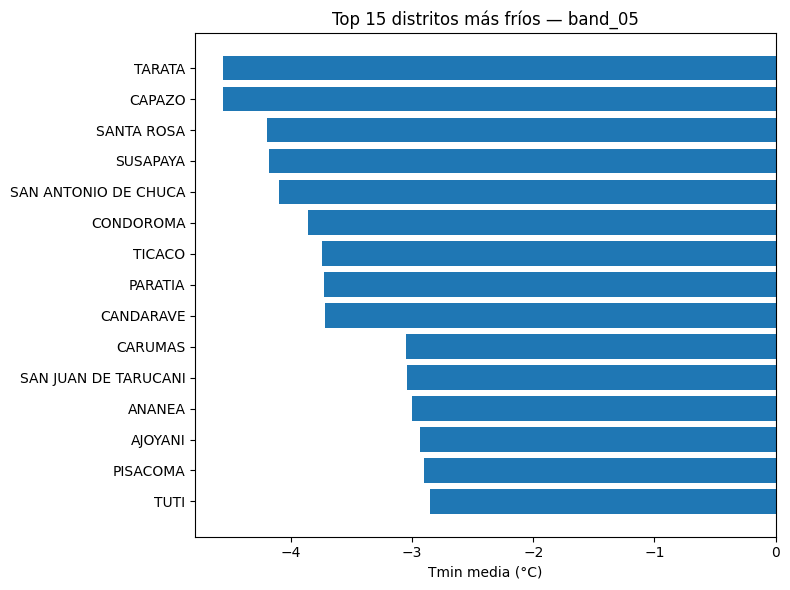

Guardado: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\ranking_tmin_mean_top15_distrito_band_05.png


In [23]:
# Top K más fríos (menor Tmin media)
top = df_one.nsmallest(RANK_K, "mean")[["__UBIGEO__", "__NOMBRE__", "mean"]].reset_index(drop=True)
# Top K más cálidos (mayor Tmin media)
bottom = df_one.nlargest(RANK_K, "mean")[["__UBIGEO__", "__NOMBRE__", "mean"]].reset_index(drop=True)

OUT_TOP = DATA / f"ranking_tmin_mean_top{RANK_K}_distrito_{DEFAULT_BAND}.csv"
OUT_BOT = DATA / f"ranking_tmin_mean_bottom{RANK_K}_distrito_{DEFAULT_BAND}.csv"
top.to_csv(OUT_TOP, index=False, encoding="utf-8")
bottom.to_csv(OUT_BOT, index=False, encoding="utf-8")
print("Guardados:", OUT_TOP, "y", OUT_BOT)

# PNG del Top K más fríos (para poner en la app si quieres)
plt.figure(figsize=(8,6))
plt.barh(top["__NOMBRE__"][::-1], top["mean"][::-1])
plt.xlabel("Tmin media (°C)")
plt.title(f"Top {RANK_K} distritos más fríos — {DEFAULT_BAND}")
plt.tight_layout()
RANK_PNG = DATA / f"ranking_tmin_mean_top{RANK_K}_distrito_{DEFAULT_BAND}.png"
plt.savefig(RANK_PNG, dpi=150)
plt.show()
print("Guardado:", RANK_PNG)


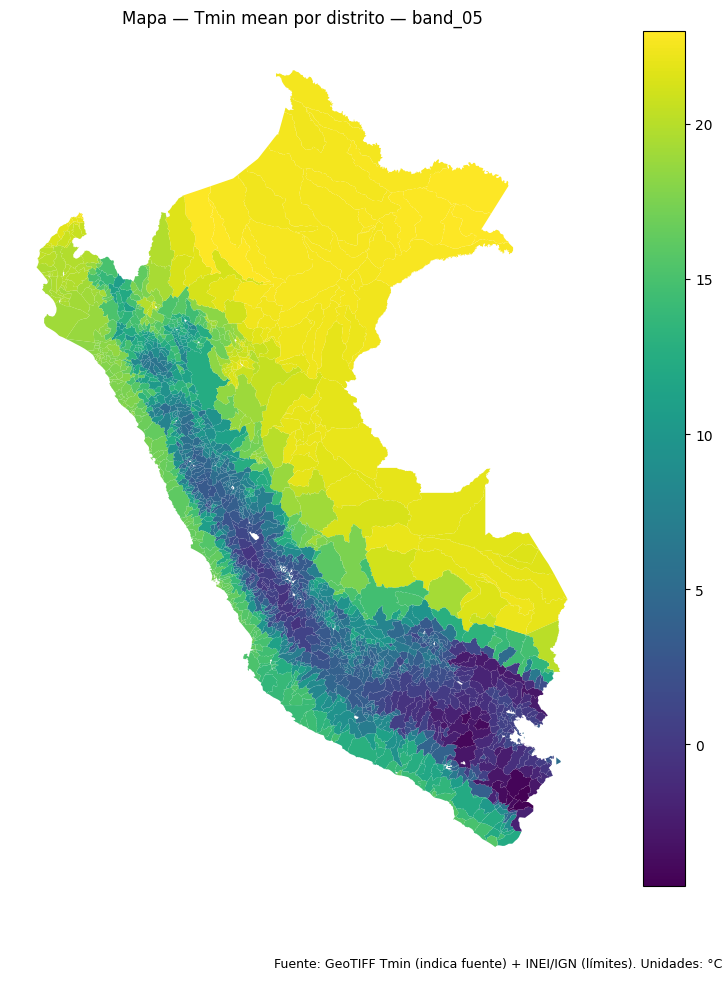

Guardado: c:\Users\Usuario\Desktop\CICLOWAA8\data science\Minimum-Temperature-Raster\data\mapa_tmin_mean_distrito_band_05.png


In [24]:
# Une métricas al GeoDataFrame para dibujar el mapa
gmap = gdf.merge(df_one[["__UBIGEO__", MAP_VAR]], left_on="__UBIGEO__", right_on="__UBIGEO__", how="left")

# Dibuja choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gmap.plot(column=MAP_VAR, ax=ax, legend=True)  # paleta por defecto
ax.set_axis_off()
titulo = f"Mapa — Tmin {MAP_VAR} por distrito — {DEFAULT_BAND}"
ax.set_title(titulo, fontsize=12)

# Pie de fuente
plt.annotate("Fuente: GeoTIFF Tmin (indica fuente) + INEI/IGN (límites). Unidades: °C.",
             xy=(0.5, 0.02), xycoords="figure fraction", ha="center", fontsize=9)

OUT_MAP = DATA / f"mapa_tmin_{MAP_VAR}_distrito_{DEFAULT_BAND}.png"
plt.tight_layout()
plt.savefig(OUT_MAP, dpi=150, bbox_inches="tight")
plt.show()
print("Guardado:", OUT_MAP)


In [25]:
print("Resumen de salidas para la app:")
print("- CSV maestro:", OUT_MASTER.name)
print("- Banda por defecto:", DEFAULT_BAND)
print("- Distribución PNG:", OUT_DIST.name)
print("- Ranking CSV (Top):", OUT_TOP.name)
print("- Ranking CSV (Bottom):", OUT_BOT.name)
print("- Ranking PNG:", RANK_PNG.name)
print("- Mapa PNG:", OUT_MAP.name)


Resumen de salidas para la app:
- CSV maestro: tmin_zstats_distrito.csv
- Banda por defecto: band_05
- Distribución PNG: dist_tmin_mean_distrito_band_05.png
- Ranking CSV (Top): ranking_tmin_mean_top15_distrito_band_05.csv
- Ranking CSV (Bottom): ranking_tmin_mean_bottom15_distrito_band_05.csv
- Ranking PNG: ranking_tmin_mean_top15_distrito_band_05.png
- Mapa PNG: mapa_tmin_mean_distrito_band_05.png
